In [121]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from electra_package.release_2 import *

In [122]:
path = "./data/feedback_release_1/"
use_cases = os.listdir(path)

use_case1 = os.listdir(path+use_cases[0])[1]
use_case2 = os.listdir(path+use_cases[1])[0]
use_case3 = os.listdir(path+use_cases[2])[0]
use_case4 = os.listdir(path+use_cases[3])[0]

print(f"{use_case1}, {use_case2}, {use_case3}, {use_case4}")

G_92050855_92050856_Correcto200C.json, G_92049646_92049647_Codigo200.json, G_92049630_92049646.json, G_92050860_92050861_ErrorAPI500.json


In [123]:
with open(path+use_cases[0]+"/"+use_case1, 'r') as archivo:
    caso1 = json.load(archivo)
    
with open(path+use_cases[1]+"/"+use_case2, 'r') as archivo:
    caso2 = json.load(archivo)
    
with open(path+use_cases[2]+"/"+use_case3, 'r') as archivo:
    caso3 = json.load(archivo)

with open(path+use_cases[3]+"/"+use_case4, 'r') as archivo:
    caso4 = json.load(archivo)

In [124]:
def preprocess(vano):

    # Extract vano ID, vano length and save id
    idv, vano_length, cond_values, apoyo_values, vert_values, extremos_values = (
        extract_vano_values(vano)
    )
    del vano["LIDAR"]

    ###############################################

    logger.critical(f"\nReference {idv}")

    # Create new attributes for data element (dictionary)
    # Declare fit evaluation results as default
    response_vano = {}
    response_vano["ID_VANO"] = idv
    response_vano["CONDUCTORES_CORREGIDOS"] = {}
    response_vano["PARAMETROS_a_h_k"] = {}  # PARAMETROS(a,h,k)
    response_vano["FLAG"] = "None"
    response_vano["NUM_CONDUCTORES"] = 0
    response_vano["NUM_CONDUCTORES_FIABLE"] = False
    response_vano["CONFIG_CONDUCTORES"] = "None"
    response_vano["COMPLETITUD"] = "None"
    response_vano["RECONSTRUCCION"] = ""
    response_vano["PUNTUACION_APRIORI"] = {
        "P_HUECO": -99,
        "DIFF2D": -99.0,
        "NOTA": -99.0,
    }
    # response_vano["PUNTUACION_APOSTERIORI"] = {"P_VALUE": -99, "CORRELATION": -99.0, "RMSE" : -99.0, "NOTA" : -99.0}

    # response_vano["PORCENTAJE_HUECOS"] = 0
    # response_vano["ERROR_POLILINEA"] = 0
    # response_vano["ERROR_CATENARIA"] = 0

    ###############################################

    response_vano["PUNTUACION_APRIORI"] = puntuacion_apriori(
        cond_values, extremos_values, apoyo_values, vert_values, vano_length
    )

    if response_vano["PUNTUACION_APRIORI"] == {
        "P_HUECO": -99,
        "DIFF2D": -99.0,
        "NOTA": -99.0,
    }:
        response_vano["FLAG"] = "bad_backings"
    ###############################################

    # mat, rotated_conds, rotated_apoyos, rotated_vertices, rotated_extremos = rotate_vano(cond_values, extremos_values, apoyo_values, vert_values)
    initial_conductor_number, expected_conductor_number, empty_poli = (
        analyze_polilinia_values(vert_values, cond_values, vano_length)
    )

    logger.info(
        f"Expected conductors from data: {initial_conductor_number - empty_poli}"
    )
    logger.info(f"Number of empty lines from data: {empty_poli}")

    if (
        initial_conductor_number - empty_poli > 3 and expected_conductor_number != 3
    ):  # TWO CONDITIONS FOR POLILINEAS

        logger.error(
            f"3 conductors expected, found {initial_conductor_number - empty_poli}"
        )
        response_vano["FLAG"] = "bad_cond_number"

        response_vano["PUNTUACION_APRIORI"] = {
            "P_HUECO": -99,
            "DIFF2D": -99.0,
            "NOTA": -99.0,
        }

        return response_vano, -1

    elif initial_conductor_number - empty_poli == 0:

        logger.warning("No polilineas...")
        response_vano["FLAG"] = "no_polilineas"

    elif empty_poli != 0:

        # logger.warning(f"Empty polilinea = {empty_pol_num}")
        response_vano["FLAG"] = "found_empty_polis"

    ################################################

    logger.critical(f"Puntuaciones apriori: {response_vano['PUNTUACION_APRIORI']}")

    # logger.info(f"Downsampling LIDAR to 25%")
    # apoyo_values, cond_values = down_sample_lidar(apoyo_values, cond_values)

    logger.info(
        f"Backings cloud shape: {apoyo_values.shape}, Conductor cloud shape: {cond_values.shape}"
    )

    if cond_values.shape[1] < 100 or apoyo_values.shape[1] < 100:

        logger.error("Empty point cloud")
        response_vano["FLAG"] = "empty_cloud"

        # response_vano["PUNTUACION_APRIORI"] = {"P_HUECO": -99, "DIFF2D": -99.0, "NOTA" : -99.0}

        return response_vano, -1

    ###############################################

    extremos_values = analyze_backings(vano_length, apoyo_values, extremos_values)

    if extremos_values == -1:

        # Include flag of bad extreme values
        # Set the line value of this element as 0 ****
        logger.error(f"Bad backings")
        response_vano["FLAG"] = "bad_backings"

        # response_vano["PUNTUACION_APRIORI"] = {"P_HUECO": -99, "DIFF2D": -99.0, "NOTA" : -99.0}

        return response_vano, -1

    ###############################################  ROTATION ALL POINTS

    mat, rotated_conds, rotated_apoyos, rotated_vertices, rotated_extremos = (
        rotate_vano(cond_values, extremos_values, apoyo_values, vert_values)
    )

    rotated_conds = clean_outliers(rotated_conds, rotated_extremos)
    rotated_conds = clean_outliers_2(rotated_conds)

    X_scaled, scaler_x, scaler_y, scaler_z = scale_conductor(rotated_conds)
    scaled_vertices = scale_vertices(rotated_vertices, scaler_x, scaler_y, scaler_z)

    x_scaled_extremos = scaler_x.transform(
        rotated_extremos[0].reshape(-1, 1)
    ).flatten()
    y_scaled_extremos = scaler_y.transform(
        rotated_extremos[1].reshape(-1, 1)
    ).flatten()
    z_scaled_extremos = scaler_z.transform(
        rotated_extremos[2].reshape(-1, 1)
    ).flatten()

    scaled_extremos = np.array(
        [x_scaled_extremos, y_scaled_extremos, z_scaled_extremos]
    )

    # plot_data("good fit", X_scaled, [], scaled_vertices, scaled_extremos, "blue")
    # plt.show()

    ############################################### SCALE CONDS AND POLILINEA
    print(X_scaled.shape)
    config, max_var = analyze_conductor_configuration(X_scaled)
    num_empty, finc, md, mvar = extract_conductor_config(
        X_scaled, rotated_extremos, rotated_conds
    )

    response_vano["CONFIG_CONDUCTORES"] = config
    response_vano["COMPLETITUD"] = finc
    response_vano["PORCENTAJE_HUECOS"] = num_empty * 10
    response_vano["NUM_CONDUCTORES"] = md

    logger.critical(f"Max var 1, max var 2: {max_var}, {mvar}")

    if max_var == mvar:
        logger.critical("Confirmed config")
        coord = max_var

    elif config == 0:
        coord = 0

    elif config == 1:
        coord = 2

    elif max_var not in [1, -1]:
        coord = max_var
        if coord == 2:
            config = 1
        else:
            config = 0

    else:
        logger.error(f"Bad config")
        response_vano["FLAG"] = "bad_configuration"
        return response_vano, -1

    if finc == "incomplete" or (md == 0 and finc != "full"):

        logger.error(f"Empty conductor")
        response_vano["FLAG"] = "empty_conductor"

        return response_vano, -1

    return X_scaled

In [127]:
X_scaled = preprocess(caso3[0])
plot_data("", X_scaled, [], [], [], "green")

2024-09-09 18:12:46.159 | INFO     | electra_package.modules_utils:extract_vano_values:91 - Extracting vano info...
2024-09-09 18:12:46.163 | CRITICAL | __main__:preprocess:11 - 
Reference G_92049630_92049646
2024-09-09 18:12:46.164 | INFO     | electra_package.modules_preprocess:rotate_vano:161 - Rotating vano
2024-09-09 18:12:46.166 | CRITICAL | electra_package.modules_main2:analyze_polilinia_values:28 - len initial vert values: 3
2024-09-09 18:12:46.167 | INFO     | electra_package.modules_preprocess:scale_conductor:70 - Scaling conductor
2024-09-09 18:12:46.171 | CRITICAL | electra_package.modules_main2:analyze_polilinia_values:83 - max variances: [1, 1, 1]
2024-09-09 18:12:46.172 | CRITICAL | electra_package.modules_main2:analyze_polilinia_values:91 - number of consistent vert values: 3, max variance 1
2024-09-09 18:12:46.173 | INFO     | __main__:preprocess:55 - Expected conductors from data: 3
2024-09-09 18:12:46.174 | INFO     | __main__:preprocess:58 - Number of empty lines fr

[4744692.5689, 4744692.5689, 4744281.798800001, 4744281.798800001]
(3, 954)


In [149]:
X_scaled.shape

(3, 954)

941 [0 1 2] (3, 941)


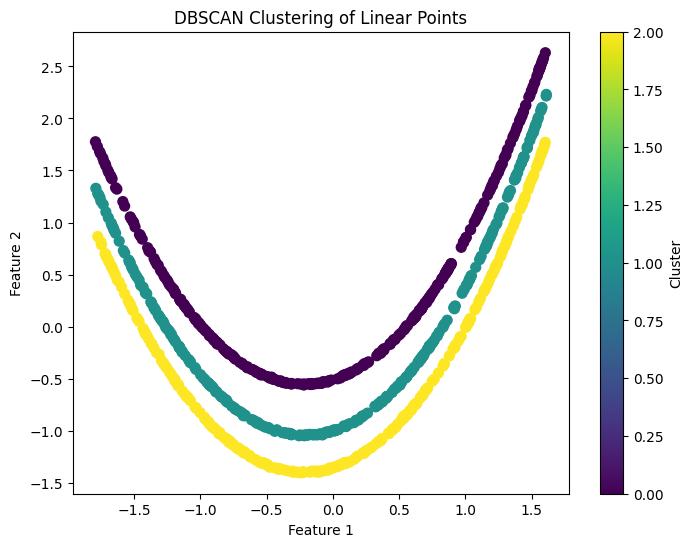

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from electra_package.modules_clustering import dbscan_find_clusters_3  # Ensure this import is correct

def filter_and_relabel_three_largest_clusters(labels, centroids, X_scaled):
    # Step 1: Identify the three largest clusters by size, excluding noise
    label_counts = Counter(labels[labels != -1])  # Exclude noise points (-1)
    three_largest_clusters = [cluster for cluster, _ in label_counts.most_common(3)]
    
    # Step 2: Create a mapping for the three largest clusters to new labels [0, 1, 2]
    cluster_mapping = {old_label: new_label for new_label, old_label in enumerate(three_largest_clusters)}

    # Step 3: Relabel the data points to have only labels [0, 1, 2]
    filtered_labels = np.array([cluster_mapping[label] for label in labels if label in three_largest_clusters])

    # Step 4: Filter the centroids for the three largest clusters
    filtered_centroids = np.array([centroids[cluster] for cluster in three_largest_clusters])
    
    # Step 5: Filter X_scaled to keep only points belonging to the three largest clusters
    filtered_X_scaled = X_scaled[:, np.isin(labels, three_largest_clusters)]

    return filtered_X_scaled, filtered_labels, filtered_centroids

# Assuming X_scaled is your input data that is already defined and preprocessed
centroids, labels = dbscan_find_clusters_3(X_scaled)  # Adjust parameters if necessary

# Example usage with your existing centroids, labels, and X_scaled
filtered_X_scaled, filtered_labels, filtered_centroids = filter_and_relabel_three_largest_clusters(labels, centroids, X_scaled)

# Check the output
print(len(filtered_labels), np.unique(filtered_labels), filtered_X_scaled.shape)

# Plot the results
plt.figure(figsize=(8, 6))

# Plot points colored by their cluster labels
plt.scatter(filtered_X_scaled[1, :], filtered_X_scaled[2, :], c=filtered_labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering of Linear Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()


In [140]:
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  0,  1,  2,  2,  1,
        0,  1,  0,  1,  1,  0,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  0,  0,  0,  2,  2,  2,  0,  0,  0,  0,
        1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  0,  0,  2,  0,  2,  2,  0,  2,  0,  1,  2,  2,  1,  0,  2,
        1,  0,  2,  1,  2,  2,  1,  0,  2,  0,  1,  2,  1,  0,  2,  1,  2,
        0,  2,  1,  0,  2,  1,  0,  2,  2,  1,  0,  2,  1,  0,  2,  1,  1,
        2,  0,  0,  0,  0,  2,  1,  1,  1,  0,  2,  2,  2,  2,  2,  2,  1,
        1,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  0,  1,
        1,  1,  2,  0,  1,  0,  1,  2,  2, -1,  0,  0,  1,  0,  1,  1,  0,
        1,  0,  1,  1,  0,  1,  0,  1,  1,  1,  0,  1,  1,  1,  1,  0,  0,
        1,  1,  0,  0,  0,  1,  1,  0,  1,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2

/home/ubuntu-deduce/Projects/electra-ia/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



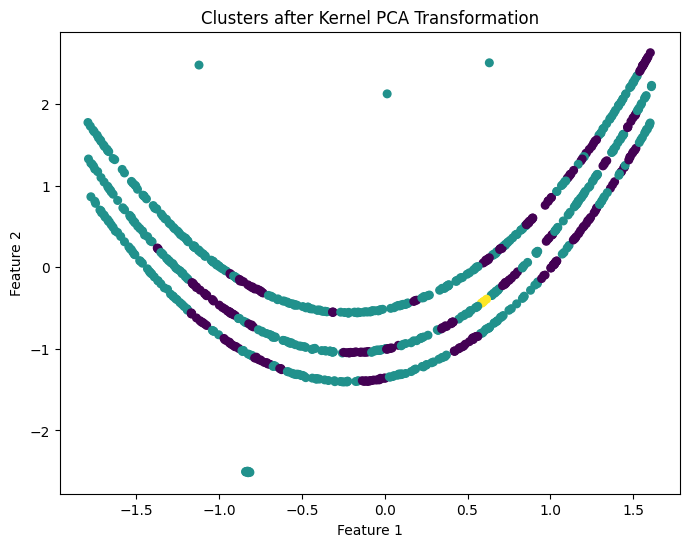

/home/ubuntu-deduce/Projects/electra-ia/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



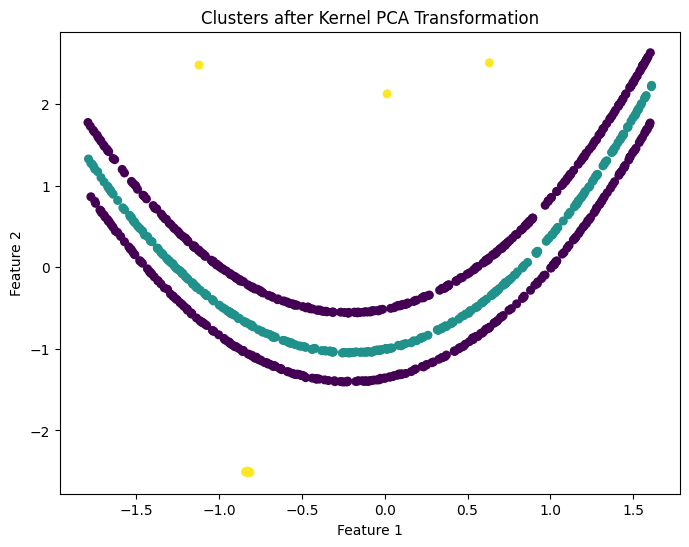

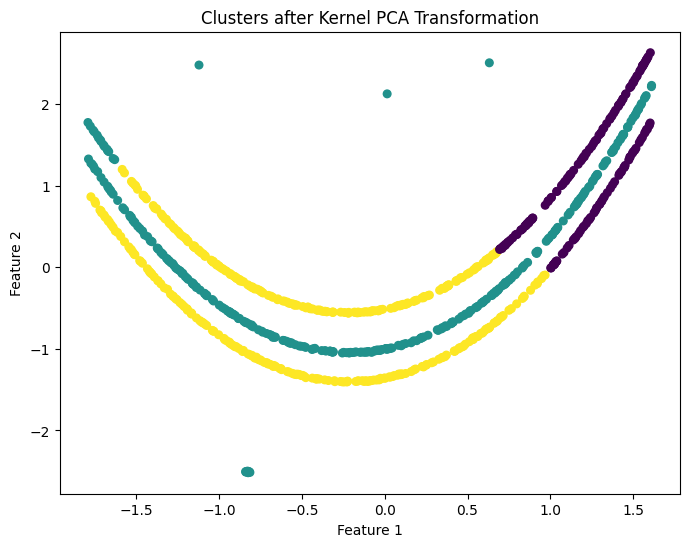

/home/ubuntu-deduce/Projects/electra-ia/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



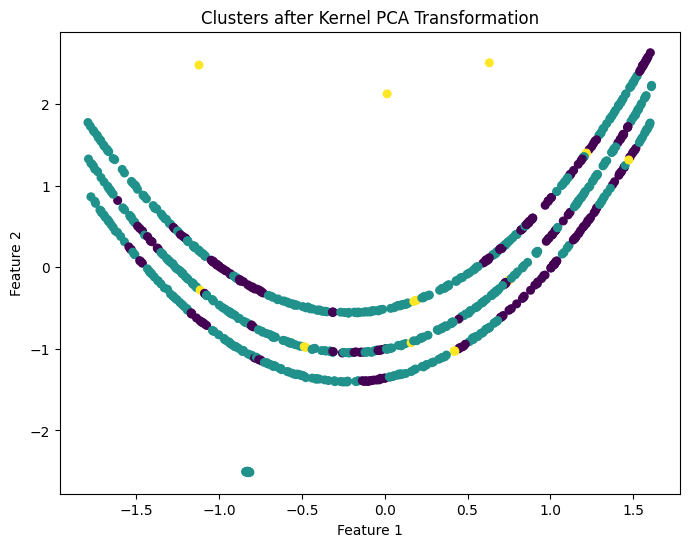

/home/ubuntu-deduce/Projects/electra-ia/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



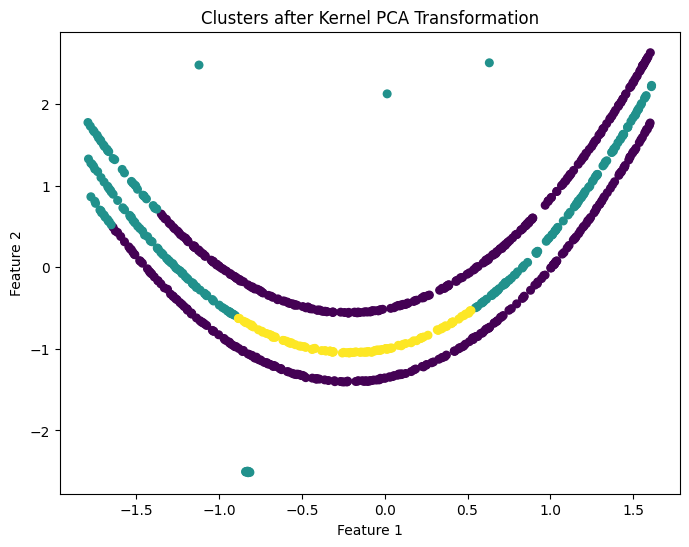

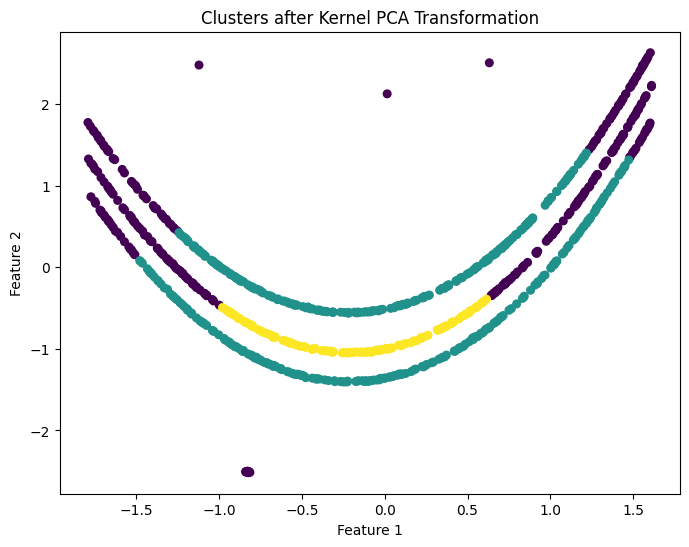

/home/ubuntu-deduce/Projects/electra-ia/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



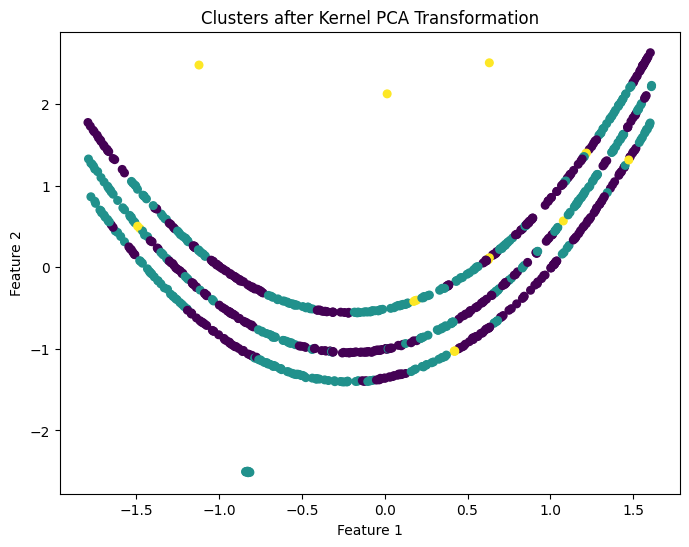

/home/ubuntu-deduce/Projects/electra-ia/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



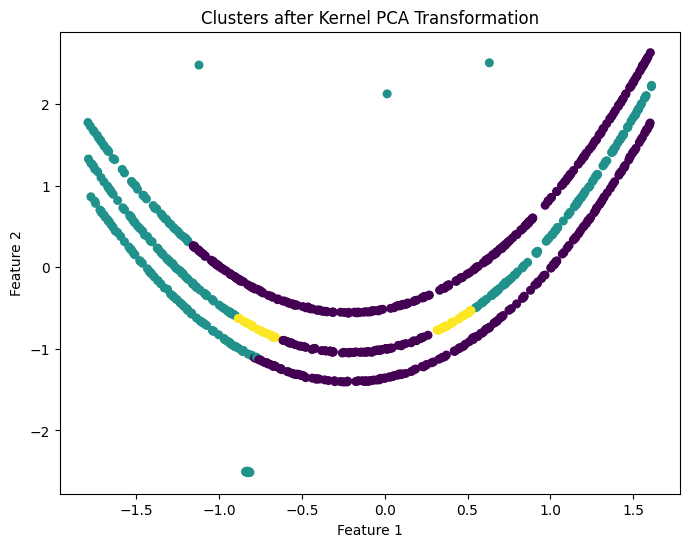

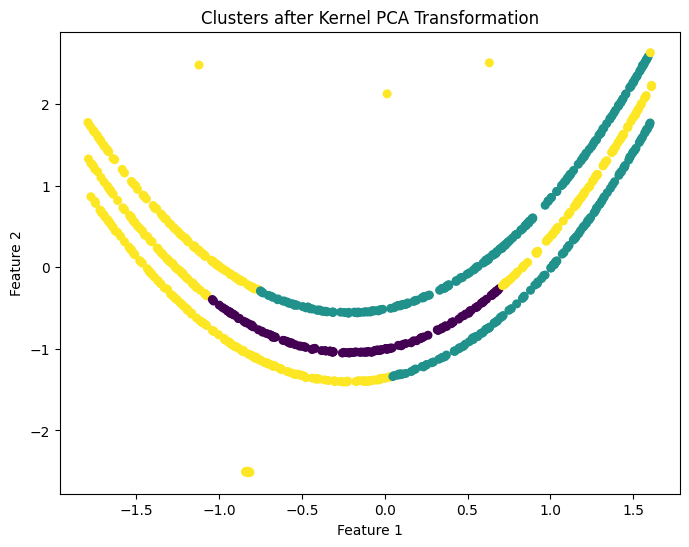

/home/ubuntu-deduce/Projects/electra-ia/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



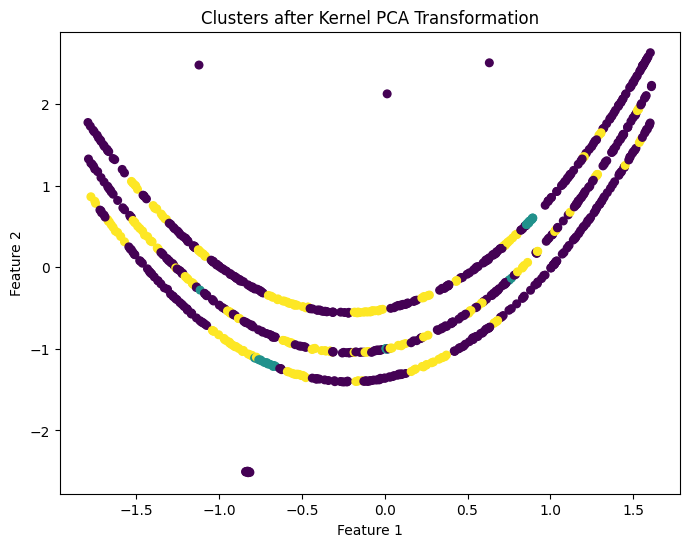

/home/ubuntu-deduce/Projects/electra-ia/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



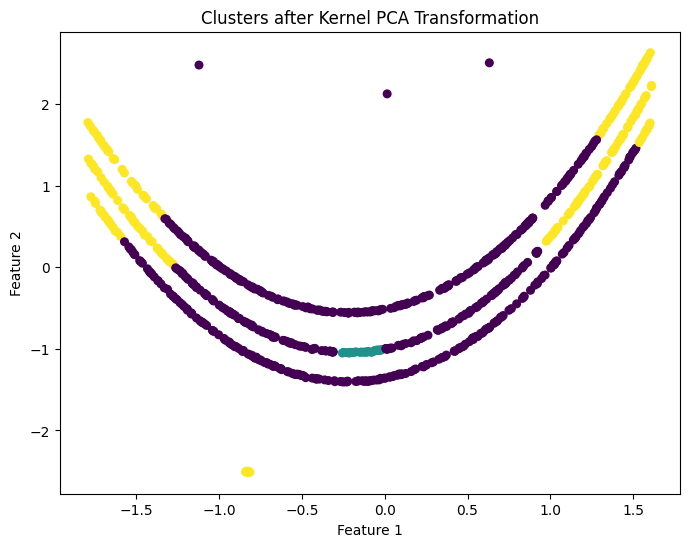

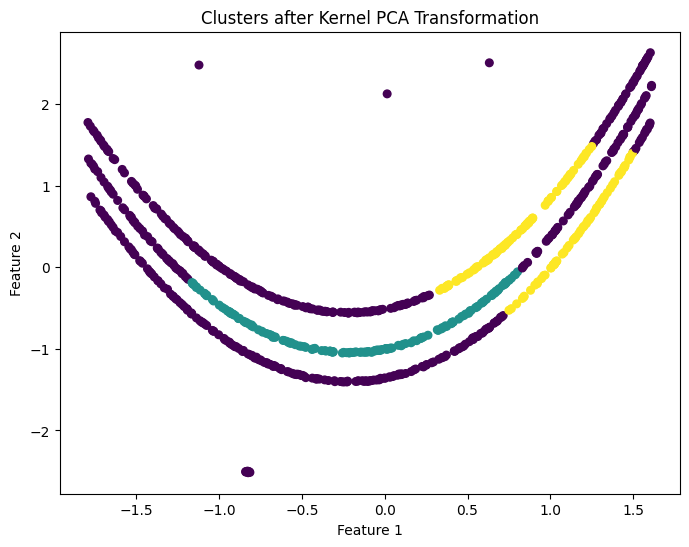

/home/ubuntu-deduce/Projects/electra-ia/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



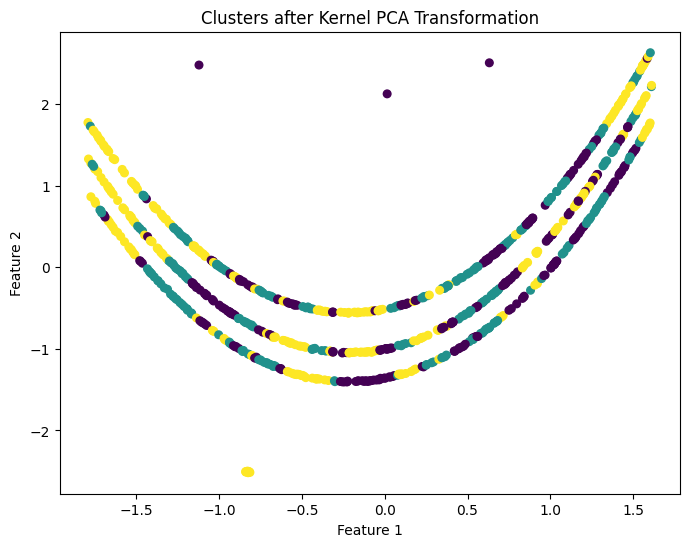

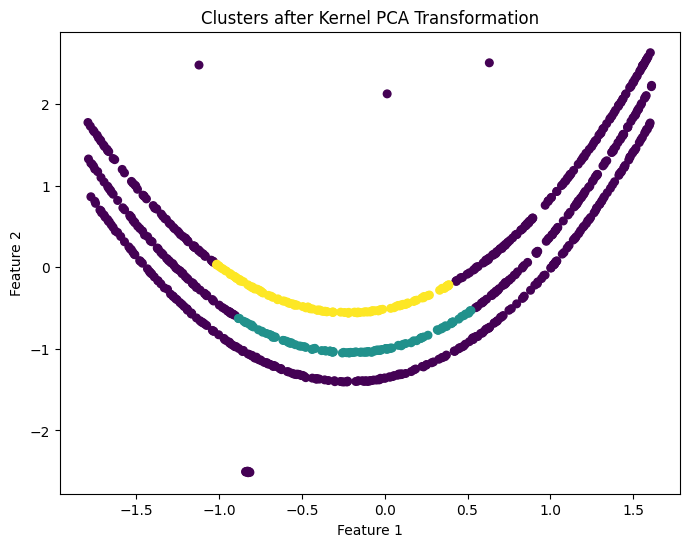

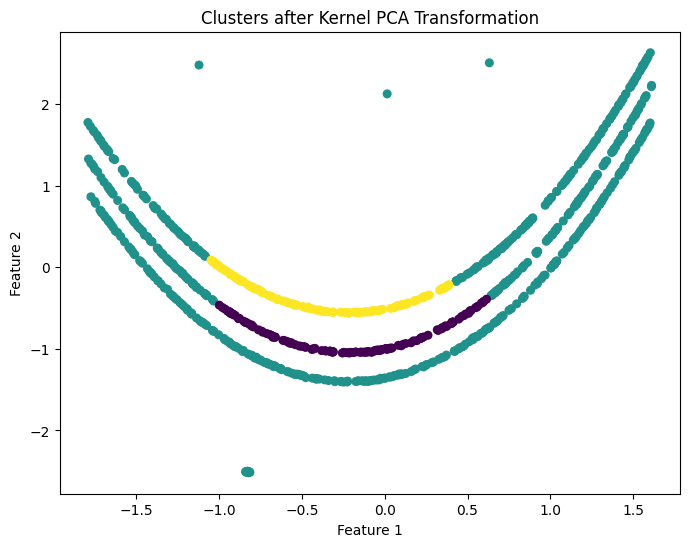

/home/ubuntu-deduce/Projects/electra-ia/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



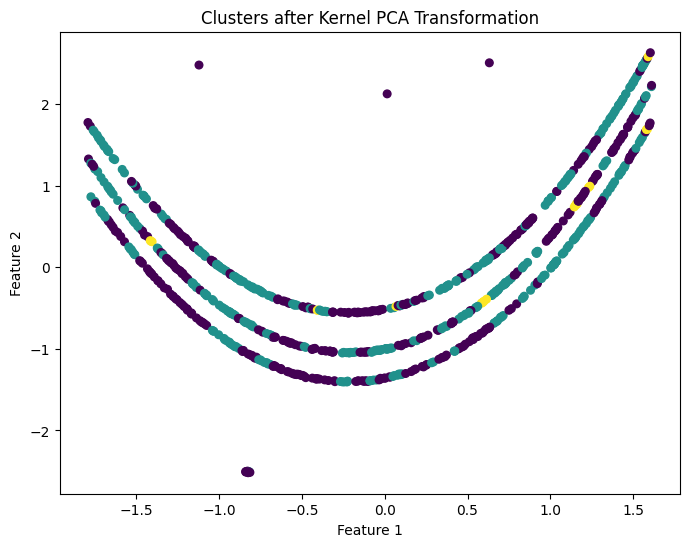

/home/ubuntu-deduce/Projects/electra-ia/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



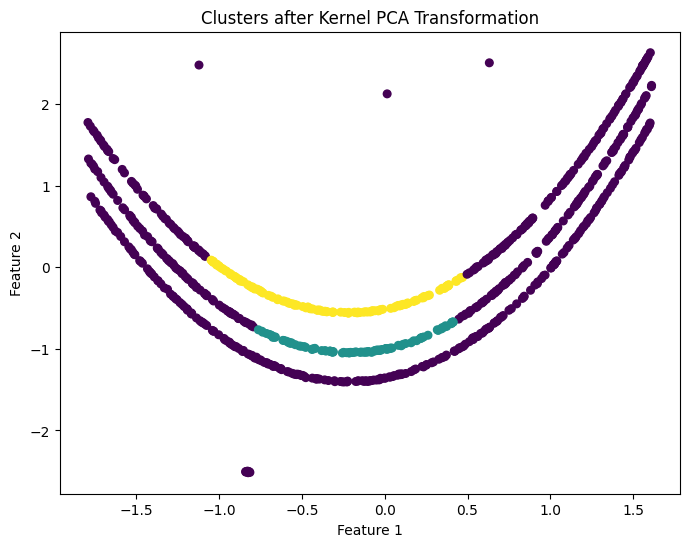

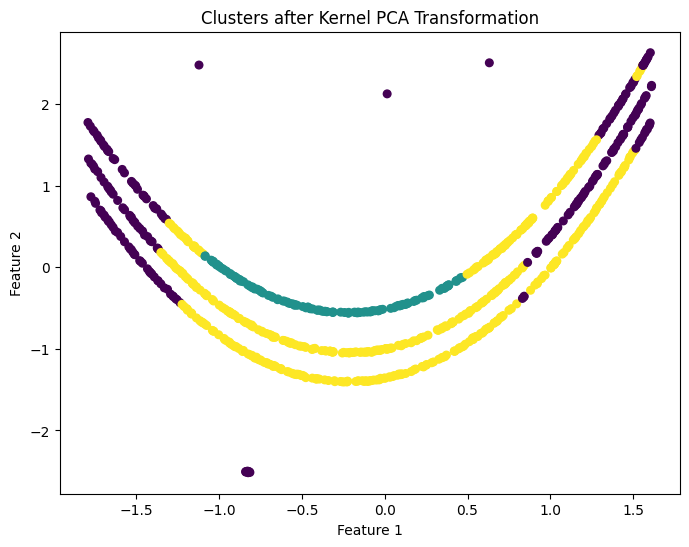

In [88]:
from sklearn.cluster import SpectralClustering
from electra_package.modules_clustering import *

for gamma in [1, 3, 5, 7, 11, 15]:
    
    for k in [3, 5, 7, 15]:
        # Apply Kernel PCA with RBF kernel
        kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
        X_kpca = kpca.fit_transform(X_scaled)

        # Apply K-Means clustering in the transformed space
        spectral_clustering = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=41, n_neighbors=k)
        clusters = spectral_clustering.fit_predict(X_kpca)

        # Plot the results
        plt.figure(figsize=(8, 6))
        plt.scatter(X_scaled[:, 1], X_scaled[:, 2], c=clusters, cmap='viridis', s=30)
        # plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=clusters, cmap='viridis', s=30)
        plt.title('Clusters after Kernel PCA Transformation')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()


In [ ]:
    # scaled_apoyos,scaler_x,scaler_y,scaler_z = scale_conductor(apoyo_values)
    # scaled_apoyos = clean_outliers_2(scaled_apoyos)

    # clusters, noise_cluster = extract_n_clusters(scaled_apoyos)

    # if noise_cluster != 0:
    #     logger.critical(f"Found noise in backings!")
    # if len(clusters) == 3:
    #     logger.critical(f"Found {len(clusters)} backings!")
    #     return -1